In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

from torchsummary import summary

import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


In [3]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-lpi3tufq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-lpi3tufq
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=a9c299cf21c353d49fdb62e0ff2843783a4244f9f50cc7df3d132e74ada927d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-ojaofx47/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Prepair Dataset

In [ ]:
!git clone https://github.com/folfcoder/recaptcha-dataset.git

Cloning into 'recaptcha-dataset'...
remote: Enumerating objects: 11754, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 11754 (delta 5), reused 1 (delta 0), pack-reused 11742
Receiving objects: 100% (11754/11754), 395.64 MiB | 28.70 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (11779/11779), done.


In [ ]:
!rm -rf ./recaptcha-dataset/Large/Mountain/
!rm -rf ./recaptcha-dataset/Large/Other/
!rm -rf ./recaptcha-dataset/Large/readme.txt

ImageFolder structure

```
data_dir/Bicycle/xxx.png
data_dir/Bicycle/xxy.png
data_dir/Bicycle/[...]/xxz.png
...
data_dir/Traffic Light/123.png
data_dir/Traffic Light/nsdf3.png
data_dir/Traffic Light/[...]/asd932_.png
```



In [5]:
data_dir = "/gdrive/MyDrive/computer_vision/Large"
class_names = ['Bicycle', 'Bridge', 'Bus', 'Car',
               'Chimney', 'Crosswalk', 'Hydrant',
               'Motorcycle', 'Palm', 'Traffic Light']

input_size = 224
batch_size = 32

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

print("Initializing Datasets and Dataloaders...")

image_datasets = datasets.ImageFolder(data_dir, data_transforms)  # your dataset
num_data = len(image_datasets)
indices = np.arange(num_data)
np.random.shuffle(indices)

train_size = int(num_data*0.8)
train_indices = indices[:train_size]
val_indices = indices[train_size:]
train_set = torch.utils.data.Subset(image_datasets, train_indices)
val_set = torch.utils.data.Subset(image_datasets, val_indices)

print('Number of training data:', len(train_set))
print('Number of validation data:', len(val_set))

dataloaders = {'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4),
                 'val': torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)}

Initializing Datasets and Dataloaders...
Number of training data: 3512
Number of validation data: 878


In [6]:
def imshow(imgs, title=None):
    """Display image for Tensor."""
    imgs = imgs.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + mean
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    if title is not None:
        plt.title(title)

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


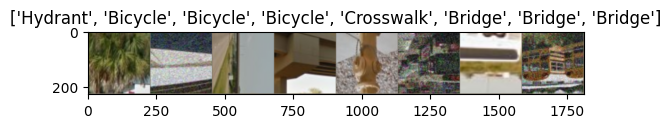

In [7]:
# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


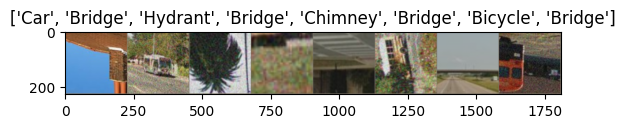

In [8]:
# Get a batch of validation data
inputs, labels = next(iter(dataloaders['val']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

## Build model

### ResNet from scratch

![resnet](https://pytorch.org/assets/images/resnet.png)

In [9]:
class Block(nn.Module):

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [10]:
class ResNet_18(nn.Module):

    def __init__(self, image_channels, num_classes):

        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def __make_layer(self, in_channels, out_channels, stride):

        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)

        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            Block(out_channels, out_channels)
        )

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def identity_downsample(self, in_channels, out_channels):

        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )

In [11]:
model = ResNet_18(image_channels=3, num_classes=10)
summary(model, (3, 224, 224), device='cpu')
# summary(model, (3, 512, 512), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
            Block-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Resnet from model zoo

In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [14]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

num_classes = 10
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
summary(model_ft, (3, 224, 224), device='cpu')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Train model

In [15]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    model = model.to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [16]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [18]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 1.2086 Acc: 0.6054
val Loss: 0.7422 Acc: 0.7620

Epoch 1/19
----------
train Loss: 0.6008 Acc: 0.8112
val Loss: 0.5235 Acc: 0.8383

Epoch 2/19
----------
train Loss: 0.4635 Acc: 0.8556
val Loss: 0.4159 Acc: 0.8645

Epoch 3/19
----------
train Loss: 0.4309 Acc: 0.8650
val Loss: 0.3876 Acc: 0.8724

Epoch 4/19
----------
train Loss: 0.3551 Acc: 0.8855
val Loss: 0.3657 Acc: 0.8747

Epoch 5/19
----------
train Loss: 0.3337 Acc: 0.8932
val Loss: 0.3078 Acc: 0.9032

Epoch 6/19
----------
train Loss: 0.2980 Acc: 0.9046
val Loss: 0.3046 Acc: 0.8929

Epoch 7/19
----------
train Loss: 0.3016 Acc: 0.9049
val Loss: 0.3231 Acc: 0.8941

Epoch 8/19
----------
train Loss: 0.2663 Acc: 0.9114
val Loss: 0.3378 Acc: 0.8986

Epoch 9/19
----------
train Loss: 0.2641 Acc: 0.9120
val Loss: 0.2957 Acc: 0.9055

Epoch 10/19
----------
train Loss: 0.2537 Acc: 0.9146
val Loss: 0.2391 Acc: 0.9169

Epoch 11/19
----------
train Loss: 0.2507 Acc: 0.9220
val Loss: 0.2677 Acc: 0.9157

Ep

## Save the model & features

In [ ]:
# torch.save(model_ft.state_dict(), 'resnet18.pt')

In [19]:
torch.save(model_ft, 'resnet_ft.pt')

In [20]:
data_dir = "/gdrive/MyDrive/computer_vision/QC"
q_data_dir = "/gdrive/MyDrive/computer_vision/q"
class_names = ['Bicycle', 'Bridge', 'Bus', 'Car',
               'Chimney', 'Crosswalk', 'Hydrant',
               'Motorcycle', 'Palm', 'Traffic Light']

input_size = 224
batch_size = 32

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

print("Initializing Datasets and Dataloaders...")

image_datasets = datasets.ImageFolder(data_dir, data_transforms)  # your dataset
num_data = len(image_datasets)
indices = np.arange(num_data)
train_indices = indices
train_set = torch.utils.data.Subset(image_datasets, train_indices)

q_image_datasets = datasets.ImageFolder(q_data_dir, data_transforms)  # your dataset
q_size = len(q_image_datasets)
print(num_data)
print(q_size)
dataloaders = {'train':torch.utils.data.DataLoader(train_set, batch_size=num_data, shuffle=False, num_workers=4),
               'query': torch.utils.data.DataLoader(q_image_datasets, batch_size=q_size, shuffle=False, num_workers=4)}

Initializing Datasets and Dataloaders...
207
100


In [21]:
input_size = 224 #data resize 시 사용!
batch_size = 200 #이걸 바꿔가면서 뭐가 성능좋은지 check!
import torch
import clip
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
class_names = ['Bicycle', 'Bridge', 'Bus', 'Car',
               'Chimney', 'Crosswalk', 'Hydrant',
               'Motorcycle', 'Palm', 'Traffic Light']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)
model.to(device)
train_inputs, train_labels = next(iter(dataloaders['train']))
inputs, labels = next(iter(dataloaders['query']))
train_inputs = train_inputs.to(device)
inputs = inputs.to(device)
train_Results = []
Results = []
train_classname = []
test_classname = []
for i in range(len(train_inputs)):
  res = []
  res_pos = []
  label = class_names[train_labels[i]]
  class_name = clip.tokenize(class_names).to(device)
  train_classname.append(label)

  image_input = train_inputs[i].unsqueeze(0).to(device)
  with torch.no_grad():
      image_features = model.encode_image(image_input)
      text_features = model.encode_text(class_name)

  # Pick the top 5 most similar labels for the image
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  values, indices = similarity[0].topk(10)
  # Print the result

  for value, index in zip(values, indices):
      res.append(class_names[index])
      res_pos.append(100 * value.item())
  rp = []
  for a in class_names:
    rp.append(res_pos[res.index(a)])
  train_Results.append(rp)
for i in range(len(inputs)):
  res = []
  res_pos = []
  label = class_names[labels[i]]
  class_name = clip.tokenize(class_names).to(device)
  test_classname.append(label)

  image_input = inputs[i].unsqueeze(0).to(device)
  with torch.no_grad():
      image_features = model.encode_image(image_input)
      text_features = model.encode_text(class_name)

  # Pick the top 5 most similar labels for the image
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  values, indices = similarity[0].topk(10)
  # Print the result

  for value, index in zip(values, indices):
      res.append(class_names[index])
      res_pos.append(100 * value.item())
  rp = []
  for a in class_names:
    rp.append(res_pos[res.index(a)])
  Results.append(rp)


#   if res[0] == label:
#     print(res[0],label)
#     correct += 1
#     t3_correct +=1
#   elif label in res[:3]:
#     print(label, res[:3],res_pos[:3])
#     t3_correct +=1
#   else:
#     print(label,res,res_pos)

# print("정확도 :", (correct/len(labels))*100)
# print("t3 정확도 :", (t3_correct/len(labels))*100)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 258MiB/s]


In [25]:
#이 feature 사용
import torch.nn.functional as F
model_ft = torch.load('resnet_ft.pt')
modules = list(model_ft.children())[:-1]
alex_feat = nn.Sequential(*modules)
for p in alex_feat.parameters():
    p.requires_grad = False

query_features = []
query_labels = []
for inputs, labels in dataloaders['query']:
    inputs = inputs.to(device)
    query_h = alex_feat(inputs)
    for input in query_h:
      i = input.view(-1)
      query_features.append(i.tolist())
    for label in labels:
      query_labels.append(label.tolist())


train_features = []
train_labels = []
for inputs, labels in dataloaders['train']:
    inputs = inputs.to(device)
    train_h = alex_feat(inputs)
    for input in train_h:
      # print(pooled.shape)  # torch.Size([256, 1, 1])
      i = input.view(-1)
      train_features.append(i.tolist())
    for label in labels:
      train_labels.append(class_names[label])

    # train_labels += labels.tolist()
    # break
    # train_features.append(train_h.squeeze())
    # train_labels.append(labels)
    # print(train_h.shape)      # [32, 512, 1, 1]


In [ ]:
import torch.nn.functional as F
model_ft = torch.load('alex_ft.pt')
modules = list(model_ft.children())[:-1]
alex_feat = nn.Sequential(*modules)
for p in alex_feat.parameters():
    p.requires_grad = False

query_features = []
query_labels = []
for inputs, labels in dataloaders['query']:
    inputs = inputs.to(device)
    query_h = alex_feat(inputs)
    for input in query_h:
      pooled = F.adaptive_avg_pool2d(input, (1, 1))
      # print(pooled.shape)  # torch.Size([256, 1, 1])
      i = pooled.squeeze()
      query_features.append(i.tolist())
    for label in labels:
      query_labels.append(label.tolist())


train_features = []
train_labels = []
for inputs, labels in dataloaders['train']:
    print(labels)
    inputs = inputs.to(device)
    train_h = alex_feat(inputs)
    for input in train_h:
      pooled = F.adaptive_avg_pool2d(input, (1, 1))
      # print(pooled.shape)  # torch.Size([256, 1, 1])

      i = pooled.squeeze()
      train_features.append(i.tolist())
    for label in labels:

      train_labels.append(class_names[label])
print(len(train_features[0]))
print(len(train_labels))
    # train_labels += labels.tolist()
    # break
    # train_features.append(train_h.squeeze())
    # train_labels.append(labels)
    # print(train_h.shape)      # [32, 512, 1, 1]


tensor([2, 6, 2, 9, 6, 6, 9, 8, 6, 3, 0, 0, 5, 4, 5, 3, 5, 1, 2, 3, 8, 4, 3, 6,
        9, 5, 6, 3, 3, 0, 4, 8, 7, 4, 7, 5, 8, 1, 9, 7, 3, 4, 8, 0, 2, 9, 0, 7,
        0, 2, 4, 7, 0, 5, 1, 0, 5, 4, 4, 8, 1, 1, 8, 1, 5, 5, 3, 7, 9, 9, 4, 4,
        9, 3, 3, 7, 3, 9, 8, 1, 6, 6, 8, 0, 3, 0, 9, 2, 1, 0, 9, 3, 0, 3, 0, 9,
        1, 9, 0, 1, 0, 6, 4, 8, 5, 7, 6, 2, 1, 8, 5, 3, 2, 2, 6, 1, 6, 1, 3, 5,
        8, 1, 8, 6, 0, 6, 9, 5, 4, 7, 5, 0, 6, 3, 8, 9, 8, 2, 8, 1, 6, 4, 5, 0,
        0, 2, 1, 7, 1, 7, 0, 9, 8, 7, 0, 5, 7, 2, 7, 7, 5, 0, 4, 8, 0, 9, 2, 6,
        7, 7, 1, 9, 3, 4, 3, 0, 2, 3, 9, 7, 1, 9, 9, 2, 2, 4, 0, 4, 6, 4, 9, 7,
        3, 0, 0, 9, 9, 6, 0, 5, 4, 5, 4, 8, 2, 5, 6])
256
207


In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
q_labels = []
for i in range(1,101):
  q_labels.append("query"+str(i)+".png")
q_labels.sort()

classifier = KNeighborsClassifier(n_neighbors = 10)

classifier.fit(train_features, train_classname)
predict_labels = classifier.predict(query_features)
for i in range(len(predict_labels)):
  print(q_labels[i]+"\t"+predict_labels[i])

query1.png	Palm
query10.png	Palm
query100.png	Bus
query11.png	Traffic Light
query12.png	Chimney
query13.png	Car
query14.png	Motorcycle
query15.png	Chimney
query16.png	Chimney
query17.png	Palm
query18.png	Palm
query19.png	Car
query2.png	Crosswalk
query20.png	Motorcycle
query21.png	Crosswalk
query22.png	Traffic Light
query23.png	Bridge
query24.png	Bicycle
query25.png	Bus
query26.png	Motorcycle
query27.png	Bicycle
query28.png	Motorcycle
query29.png	Hydrant
query3.png	Traffic Light
query30.png	Traffic Light
query31.png	Chimney
query32.png	Bicycle
query33.png	Crosswalk
query34.png	Bridge
query35.png	Car
query36.png	Palm
query37.png	Chimney
query38.png	Palm
query39.png	Traffic Light
query4.png	Bus
query40.png	Motorcycle
query41.png	Motorcycle
query42.png	Chimney
query43.png	Chimney
query44.png	Palm
query45.png	Bus
query46.png	Traffic Light
query47.png	Bicycle
query48.png	Bridge
query49.png	Palm
query5.png	Bicycle
query50.png	Bus
query51.png	Bridge
query52.png	Palm
query53.png	Bus
query54.png

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
q_labels = []
for i in range(1,101):
  q_labels.append("query"+str(i)+".png")
q_labels.sort()

#train_Results, Results, train_classname
final_train_features = []
final_query_features = []
for i in range(len(train_features)):
  final_train_features.append(train_features[i]+train_Results[i]*25)
for i in range(len(query_features)):
  final_query_features.append(query_features[i]+Results[i]*25)

classifier = KNeighborsClassifier(n_neighbors = 10)

classifier.fit(final_train_features, train_classname)
predict_labels = classifier.predict(final_query_features)
for i in range(len(predict_labels)):
  print(q_labels[i]+"\t"+predict_labels[i])

query1.png	Palm
query10.png	Palm
query100.png	Bridge
query11.png	Traffic Light
query12.png	Chimney
query13.png	Car
query14.png	Motorcycle
query15.png	Chimney
query16.png	Chimney
query17.png	Palm
query18.png	Traffic Light
query19.png	Car
query2.png	Crosswalk
query20.png	Motorcycle
query21.png	Crosswalk
query22.png	Traffic Light
query23.png	Bridge
query24.png	Bicycle
query25.png	Bus
query26.png	Car
query27.png	Palm
query28.png	Motorcycle
query29.png	Hydrant
query3.png	Chimney
query30.png	Traffic Light
query31.png	Crosswalk
query32.png	Bicycle
query33.png	Crosswalk
query34.png	Crosswalk
query35.png	Car
query36.png	Palm
query37.png	Bridge
query38.png	Palm
query39.png	Bus
query4.png	Bus
query40.png	Motorcycle
query41.png	Bicycle
query42.png	Chimney
query43.png	Chimney
query44.png	Palm
query45.png	Bus
query46.png	Bridge
query47.png	Bicycle
query48.png	Bridge
query49.png	Palm
query5.png	Bicycle
query50.png	Bus
query51.png	Bridge
query52.png	Palm
query53.png	Bus
query54.png	Bridge
query55.png	

In [28]:
neigh_ind = classifier.kneighbors(X = final_query_features, n_neighbors=10, return_distance=False) # Top-10 results
neigh_labels = np.array(train_classname)[neigh_ind]

In [29]:
print(neigh_labels)

[['Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm']
 ['Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm']
 ['Bridge' 'Bridge' 'Bridge' 'Bridge' 'Bridge' 'Bridge' 'Bridge' 'Bridge'
  'Bridge' 'Bridge']
 ['Traffic Light' 'Traffic Light' 'Traffic Light' 'Traffic Light'
  'Traffic Light' 'Traffic Light' 'Traffic Light' 'Traffic Light'
  'Traffic Light' 'Traffic Light']
 ['Chimney' 'Chimney' 'Chimney' 'Chimney' 'Chimney' 'Chimney' 'Chimney'
  'Chimney' 'Chimney' 'Chimney']
 ['Car' 'Car' 'Car' 'Car' 'Car' 'Car' 'Car' 'Car' 'Car' 'Car']
 ['Bicycle' 'Motorcycle' 'Motorcycle' 'Motorcycle' 'Motorcycle'
  'Motorcycle' 'Motorcycle' 'Motorcycle' 'Motorcycle' 'Motorcycle']
 ['Chimney' 'Chimney' 'Chimney' 'Chimney' 'Chimney' 'Chimney' 'Chimney'
  'Chimney' 'Chimney' 'Chimney']
 ['Chimney' 'Chimney' 'Chimney' 'Chimney' 'Chimney' 'Chimney' 'Chimney'
  'Chimney' 'Chimney' 'Chimney']
 ['Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Palm']
 ['Traffi

In [30]:
import csv

with open('/gdrive/MyDrive/computer_vision/c2_t2_a3.csv','w') as file :
    write = csv.writer(file)
    for i in range(len(predict_labels)):
        write.writerow([q_labels[i]] + list(neigh_labels[i]))
